# Machine Learning and Deep Learning methods

Overview:

This section is about performing comparative study as we mentioned in the previous group presentation. We will try to find the best methods to assist in identifying and mapping climate-related literature (especially in situations where there is a large number of data but labels are scarce, and human labeling is expensive and time consuming) by evaluating and comparing mertics such as runtime and accuracy of supervised machine learning model - OneVsRestClassifier, pretrained transformer model - ClimateBERT, large language model - Mistral 7B (zero/few-shot learning based methods), and SetFit (efficient few-shot learning without prompts).


#### Install and import packages

In [1]:
pip install transformers[torch]

In [2]:
pip install datasets

In [3]:
import pandas as pd
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import numpy as np
import re
import time

#### Import dataset and data exploration

In [4]:
# Here we will download the openalex dataset from the huggingface hub
filepath = hf_hub_download(repo_id="dspoka/ccai-nlp-tutorial-1", filename="openalex_data.csv", repo_type="dataset")
with open(filepath) as f:
    unlabeled_data = pd.read_csv(f)


print(f'The dataset has {unlabeled_data.shape[0]} rows and {unlabeled_data.shape[1]} columns')
print(f'The columns are: {unlabeled_data.columns.values}')
unlabeled_data.head()

The dataset has 24906 rows and 6 columns
The columns are: ['id' 'doi' 'title' 'publication_year' 'abstract' 'authors']


,id,doi,title,publication_year,abstract,authors
0,https://openalex.org/W2076977109,https://doi.org/10.1038/nature03906,Increasing destructiveness of tropical cyclone...,2005,NaN,Kerry Emanuel
1,https://openalex.org/W2171979944,https://doi.org/10.1007/s00425-003-1105-5,"Plant responses to drought, salinity and extre...",2003,NaN,"Wang-Xia Wang, Basia Vinocur, Arie Altman"
2,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,Regional vegetation die-off in response to glo...,2005,Future drought is projected to occur under war...,"David D. Breshears, Neil S. Cobb, Paul Rich, K..."
3,https://openalex.org/W2170327428,https://doi.org/10.1073/pnas.1422385112,Anthropogenic warming has increased drought ri...,2015,Significance California ranks first in the Uni...,"Noah S. Diffenbaugh, Daniel L. Swain, Danielle..."
4,https://openalex.org/W2154180993,https://doi.org/10.1038/nature04188,Impact of regional climate change on human health,2005,NaN,"Jonathan A. Patz, Diarmid Campbell-Lendrum, Tr..."


In [5]:
filepath = hf_hub_download(repo_id="dspoka/ccai-nlp-tutorial-1", filename="labelled_data.csv", repo_type="dataset")
with open(filepath) as f:
    df = pd.read_csv(f)

# We create a lower case version of the title without spaces and punctuation, to allow for merging
df["title_lcase"] = df["title"].apply(lambda x: re.sub("\W", "", x).lower() if isinstance(x, str) else x)

# We also want to get rid of documents without abstracts, as we can't use these for learning
df = df.dropna(subset=["abstract"])
print(df.shape)

df.drop(['title_lcase'], axis=1, inplace=True)
df.rename(columns={'12 - Coastal and marine Ecosystems': 'Coastal and marine ecosystems',
                             '12 - Human and managed': 'Human and managed',
                             '12 - Mountains, snow and ice': 'Mountains, snow and ice',
                             '12 - Rivers, lakes, and soil moisture': 'Rivers, lakes, and soil moisture',
                             '12 - Terrestrial ES': 'Terrestrial ecosystems'}, inplace=True)
df.head()

(2500, 11)


,id,abstract,title,seen,INCLUDE,Coastal and marine ecosystems,Human and managed,"Mountains, snow and ice","Rivers, lakes, and soil moisture",Terrestrial ecosystems
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [6]:
df['seen'].value_counts()

1.0    2500
Name: seen, dtype: int64

In [7]:
df[df["INCLUDE"] == 0].shape[0]

1194

In [8]:
df[df["INCLUDE"] == 1].shape[0]

1306

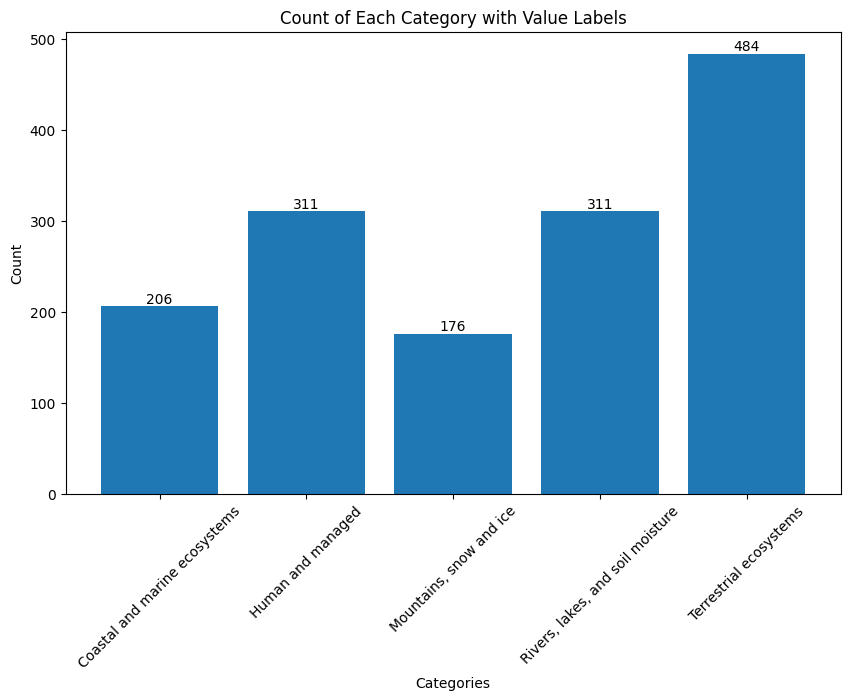

In [9]:
# Count the number of each category
label_columns = ['Coastal and marine ecosystems', 'Human and managed', 'Mountains, snow and ice',
              'Rivers, lakes, and soil moisture', 'Terrestrial ecosystems']
counts = df[label_columns].sum()

# Draw a bar chart and mark the number of each variable at the top
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values)

# Add numerical labels to the top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Count of Each Category with Value Labels')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Calculate the number of labels per row
df['label_count'] = df[label_columns].sum(axis=1)

# Number of rows with multiple labels
multiple_labels_count = (df['label_count'] > 1).sum()

# Number of rows without any labels
no_labels_count = (df['label_count'] == 0).sum()

multiple_labels_count, no_labels_count

(107, 1127)

In [11]:
from pickle import TRUE

# Filtering out rows with multiple labels or zero labels
df_clean = df[(df['label_count'] == 1)]

# Dropping the 'label_count' column as it's no longer needed
df_clean = df_clean.drop(columns=['seen', 'INCLUDE'])

df_clean = df_clean.reset_index(drop=True)

df_clean.head()

,id,abstract,title,Coastal and marine ecosystems,Human and managed,"Mountains, snow and ice","Rivers, lakes, and soil moisture",Terrestrial ecosystems,label_count
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,0.0,1.0,0.0,0.0,0.0,1.0
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,0.0,0.0,0.0,0.0,1.0,1.0
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,0.0,0.0,0.0,0.0,1.0,1.0
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,0.0,1.0,0.0,0.0,0.0,1.0
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,0.0,0.0,0.0,0.0,1.0


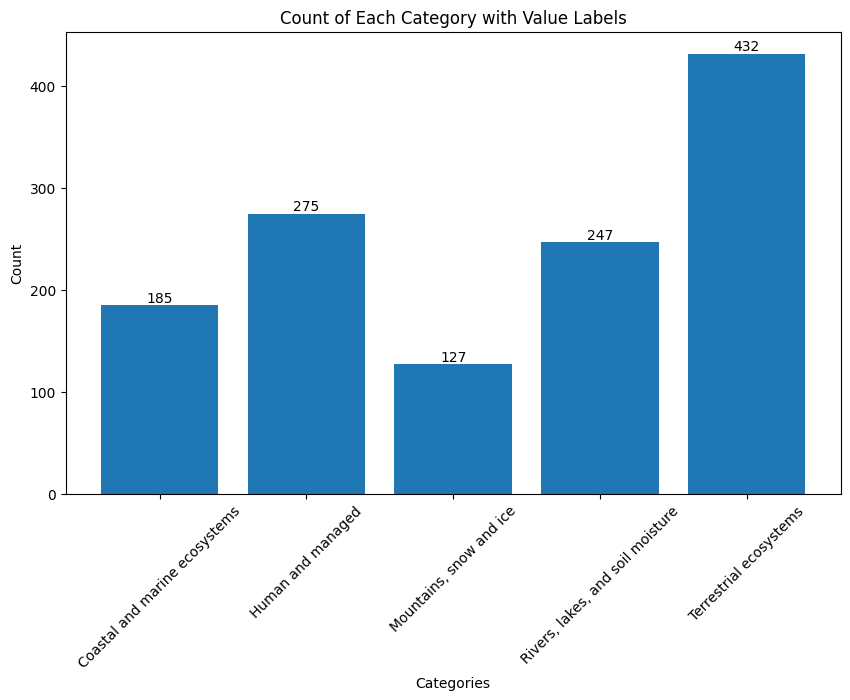

In [12]:
# Count the number of each category
label_columns = ['Coastal and marine ecosystems', 'Human and managed', 'Mountains, snow and ice',
              'Rivers, lakes, and soil moisture', 'Terrestrial ecosystems']
counts = df_clean[label_columns].sum()

# Draw a bar chart and mark the number of each variable at the top
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values)

# Add numerical labels to the top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Count of Each Category with Value Labels')
plt.xticks(rotation=45)
plt.show()

#### Machine Learning method: OneVsRestClassifier

Since we are dealing here with a multi-label classification task, i.e., any sample may belong to any class, so that we use the OneVsRestClassifier from sklearn here.

Algorithms such as the Perceptron, Logistic Regression, and Support Vector Machines were designed for binary classification and do not natively support classification tasks with more than two classes.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Extracting features and labels
X = df_clean['abstract']
y = df_clean[label_columns]

# List of different test sizes to evaluate
test_sizes = [0.4, 0.3, 0.2, 0.1]
accuracies = []  # To store accuracy for each test size
times = []       # To store running time for each test size

# Loop over different test sizes
for test_size in test_sizes:
    # Record the start time
    start_time = time.time()

    # Splitting the data into training and test sets with current test_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Creating a TF-IDF vectorizer and an SVC model wrapped in OneVsRestClassifier
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
    svc = SVC(kernel='linear', probability=True)
    model = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', OneVsRestClassifier(svc))
    ])

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Record the end time and calculate the elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    times.append(elapsed_time)

    # Calculate and store the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Print out the classification report for each test_size
    print(f"Classification Report for test size {test_size}:\n")
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Classification Report for test size 0.4:

Model Accuracy: 0.7731755424063116
                                  precision    recall  f1-score   support

   Coastal and marine ecosystems       0.96      0.68      0.79        74
               Human and managed       0.94      0.77      0.85       110
         Mountains, snow and ice       0.93      0.84      0.89        51
Rivers, lakes, and soil moisture       0.91      0.84      0.87        99
          Terrestrial ecosystems       0.93      0.79      0.85       173

                       micro avg       0.93      0.78      0.85       507
                       macro avg       0.94      0.78      0.85       507
                    weighted avg       0.94      0.78      0.85       507
                     samples avg       0.78      0.78      0.78       507

Classification Report for test size 0.3:

Model Accuracy: 0.7736842105263158
                                  precision    recall  f1-score   support

   Coastal and marine ecosys

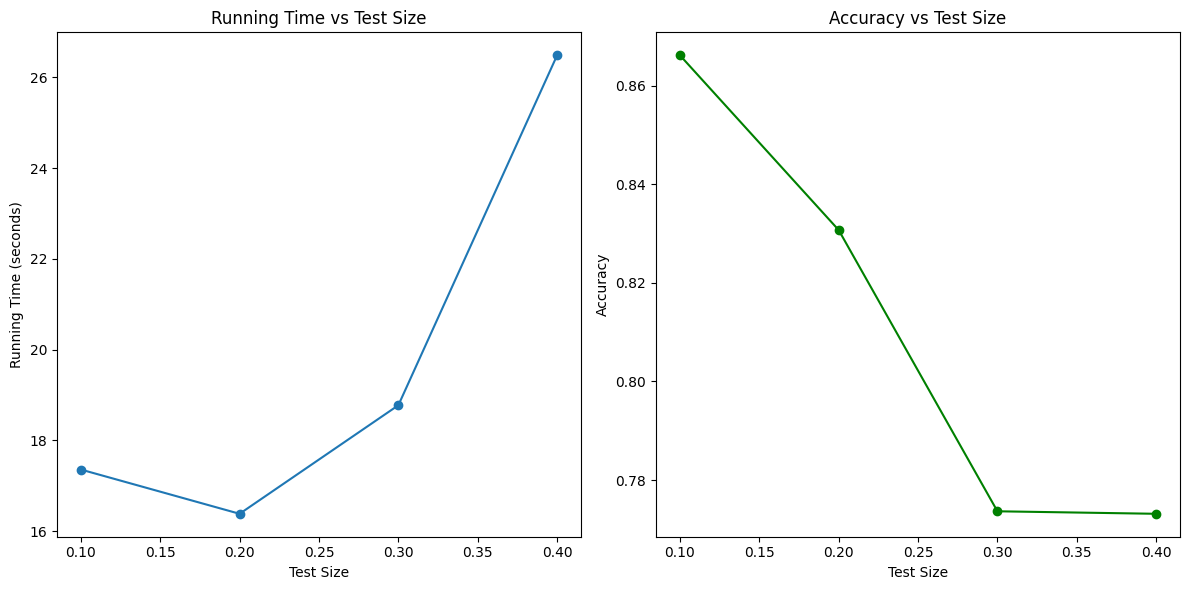

In [14]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Plot for running time
plt.subplot(1, 2, 1)
plt.plot(test_sizes, times, marker='o')
plt.title('Running Time vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Running Time (seconds)')

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(test_sizes, accuracies, marker='o', color='green')
plt.title('Accuracy vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [15]:
# Checking the distribution in the training set
distribution_train = y_train.mean()

# Checking the distribution in the test set
distribution_test = y_test.mean()

print("Distribution in the training set:\n", distribution_train)
print("\nDistribution in the test set:\n", distribution_test)

Distribution in the training set:
 Coastal and marine ecosystems       0.146620
Human and managed                   0.216857
Mountains, snow and ice             0.100088
Rivers, lakes, and soil moisture    0.194908
Terrestrial ecosystems              0.341528
dtype: float64

Distribution in the test set:
 Coastal and marine ecosystems       0.141732
Human and managed                   0.220472
Mountains, snow and ice             0.102362
Rivers, lakes, and soil moisture    0.196850
Terrestrial ecosystems              0.338583
dtype: float64


#### Transfer Learning with transformers: ClimateBERT

A more powerful way to do classification is to fine-tune a langauge model which has been pretrained on large amounts of text.

The [Transformers](https://huggingface.co/docs/transformers) library makes doing this really easy, and there are a wealth of models available with different features and which have been pretrained on different corpora. We are going to use [ClimateBert](https://huggingface.co/climatebert), which has undergone additional pretraining on texts from the climate domain (included scientific articles).

In [16]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, logging, TrainerCallback
from datasets import Dataset
import torch
from torch.nn import BCEWithLogitsLoss, Sigmoid

In [17]:
# Define the model name and load the tokenizer
model_name = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Extract texts and labels
X = df_clean['abstract'].tolist()
y = df_clean[label_columns].values

# List of different test sizes to evaluate
test_sizes = [0.4, 0.3, 0.2, 0.1]
climatebert_accuracies = []
climatebert_times = []

# Define a function to prepare the dataset
def prepare_dataset(X, y):
    encodings = tokenizer(X, truncation=True, padding=True, max_length=512)
    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': y
    })
    return dataset

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Define a custom Trainer class to handle multilabel classification
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

# Define a function to compute metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    return {"accuracy": accuracy_score(labels, predictions)}

# Define a function to record the changes of accuracy during training
class EvalLogger(TrainerCallback):
    def __init__(self):
        self.train_acc = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if 'eval_accuracy' in metrics:
            self.train_acc.append(metrics['eval_accuracy'])

eval_logger = EvalLogger()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
for test_size in test_sizes:
    start_time = time.time()

    # Split the dataset with current test_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Prepare datasets
    train_dataset = prepare_dataset(X_train, y_train)
    test_dataset = prepare_dataset(X_test, y_test)

    # Define and train the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_columns))
    trainer = MultilabelTrainer(
        model=model,
        args=TrainingArguments(
            output_dir='./results',
            num_train_epochs=3,
            per_device_train_batch_size=8,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            save_steps=500,
            save_total_limit=3,
            evaluation_strategy="no"
        ),
        train_dataset=train_dataset,
        compute_metrics=compute_metrics,
        callbacks=[eval_logger]
    )
    trainer.train()

    # Evaluate the model on the training set for training accuracy
    train_results = trainer.evaluate(train_dataset)
    print(f"Training Accuracy for test size {test_size}: {train_results['eval_accuracy']}")

    # Evaluate the model on test set
    test_results = trainer.predict(test_dataset)

    # Convert logits to probabilities and make predictions for test set
    sigmoid = Sigmoid()
    test_probabilities = sigmoid(torch.from_numpy(test_results.predictions)).numpy()
    test_predictions = (test_probabilities > 0.5).astype(int)

    # Record the end time and calculate the elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    climatebert_times.append(elapsed_time)

    # Calculate and store the accuracy
    accuracy = accuracy_score(y_test, test_predictions)
    climatebert_accuracies.append(accuracy)
    print("Accuracy:", accuracy)

    # Display classification report for the test set
    print(f"Test Set Results for test size {test_size}:")
    print(classification_report(y_test, test_predictions, target_names=label_columns, zero_division=0))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.653500
20,0.657500
30,0.654000
40,0.639400
50,0.627200
60,0.593600
70,0.539500
80,0.482000
90,0.472000
100,0.448600


Training Accuracy for test size 0.4: 0.9749670619235836
Accuracy: 0.8856015779092702
Test Set Results for test size 0.4:
                                  precision    recall  f1-score   support

   Coastal and marine ecosystems       0.87      0.96      0.91        74
               Human and managed       0.96      0.79      0.87       110
         Mountains, snow and ice       0.90      0.92      0.91        51
Rivers, lakes, and soil moisture       0.92      0.84      0.88        99
          Terrestrial ecosystems       0.86      0.95      0.90       173

                       micro avg       0.90      0.89      0.89       507
                       macro avg       0.90      0.89      0.89       507
                    weighted avg       0.90      0.89      0.89       507
                     samples avg       0.89      0.89      0.89       507



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.667600
20,0.672600
30,0.657100
40,0.643900
50,0.632800
60,0.610100
70,0.553600
80,0.514100
90,0.466300
100,0.454000


Training Accuracy for test size 0.3: 0.981941309255079
Accuracy: 0.8973684210526316
Test Set Results for test size 0.3:
                                  precision    recall  f1-score   support

   Coastal and marine ecosystems       0.85      0.96      0.91        55
               Human and managed       0.96      0.83      0.89        83
         Mountains, snow and ice       0.92      0.92      0.92        38
Rivers, lakes, and soil moisture       0.92      0.89      0.90        74
          Terrestrial ecosystems       0.92      0.92      0.92       130

                       micro avg       0.92      0.90      0.91       380
                       macro avg       0.91      0.90      0.91       380
                    weighted avg       0.92      0.90      0.91       380
                     samples avg       0.90      0.90      0.90       380



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.675400
20,0.663600
30,0.663200
40,0.656000
50,0.630400
60,0.603000
70,0.565000
80,0.494400
90,0.468500
100,0.425200


Training Accuracy for test size 0.2: 0.9683794466403162
Accuracy: 0.905511811023622
Test Set Results for test size 0.2:
                                  precision    recall  f1-score   support

   Coastal and marine ecosystems       0.82      1.00      0.90        37
               Human and managed       1.00      0.80      0.89        55
         Mountains, snow and ice       0.92      0.92      0.92        25
Rivers, lakes, and soil moisture       0.90      0.88      0.89        50
          Terrestrial ecosystems       0.96      0.94      0.95        87

                       micro avg       0.93      0.91      0.92       254
                       macro avg       0.92      0.91      0.91       254
                    weighted avg       0.93      0.91      0.92       254
                     samples avg       0.91      0.91      0.91       254



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.671900
20,0.662300
30,0.659300
40,0.646800
50,0.633600
60,0.610100
70,0.546700
80,0.506100
90,0.471800
100,0.433200


Training Accuracy for test size 0.1: 0.9622475856014048
Accuracy: 0.905511811023622
Test Set Results for test size 0.1:
                                  precision    recall  f1-score   support

   Coastal and marine ecosystems       0.82      1.00      0.90        18
               Human and managed       0.96      0.89      0.93        28
         Mountains, snow and ice       0.92      0.92      0.92        13
Rivers, lakes, and soil moisture       0.96      0.88      0.92        25
          Terrestrial ecosystems       0.97      0.88      0.93        43

                       micro avg       0.93      0.91      0.92       127
                       macro avg       0.93      0.92      0.92       127
                    weighted avg       0.94      0.91      0.92       127
                     samples avg       0.91      0.91      0.91       127



In [19]:
# Convert logits to probabilities and make predictions for the test set
sigmoid = Sigmoid()
test_probabilities = sigmoid(torch.from_numpy(test_results.predictions)).numpy()
test_predictions = (test_probabilities > 0.5).astype(int)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy:", accuracy)

# Display classification report for the test set
print("Test Set Results")
print(classification_report(y_test, test_predictions, target_names=['Coastal and marine ecosystems', 'Human and managed', 'Mountains, snow and ice', 'Rivers, lakes, and soil moisture', 'Terrestrial ecosystems']))

Accuracy: 0.905511811023622
Test Set Results
                                  precision    recall  f1-score   support

   Coastal and marine ecosystems       0.82      1.00      0.90        18
               Human and managed       0.96      0.89      0.93        28
         Mountains, snow and ice       0.92      0.92      0.92        13
Rivers, lakes, and soil moisture       0.96      0.88      0.92        25
          Terrestrial ecosystems       0.97      0.88      0.93        43

                       micro avg       0.93      0.91      0.92       127
                       macro avg       0.93      0.92      0.92       127
                    weighted avg       0.94      0.91      0.92       127
                     samples avg       0.91      0.91      0.91       127



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


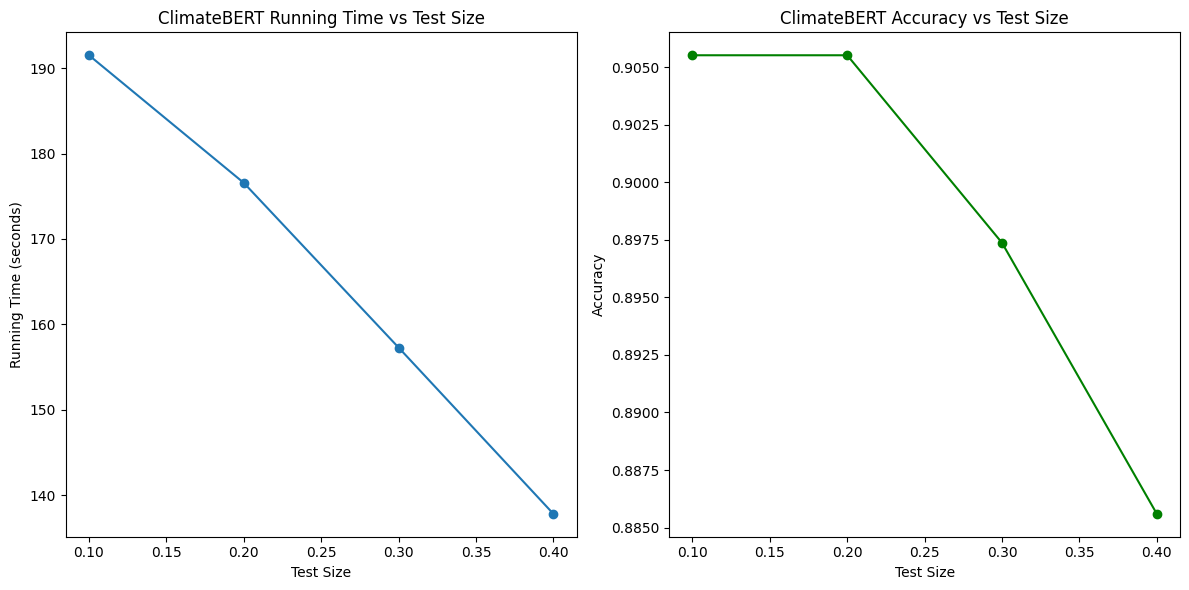

In [21]:
# Plotting the results for ClimateBERT model
plt.figure(figsize=(12, 6))

# Plot for running time
plt.subplot(1, 2, 1)
plt.plot(test_sizes, climatebert_times, marker='o')
plt.title('ClimateBERT Running Time vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Running Time (seconds)')

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(test_sizes, climatebert_accuracies, marker='o', color='green')
plt.title('ClimateBERT Accuracy vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

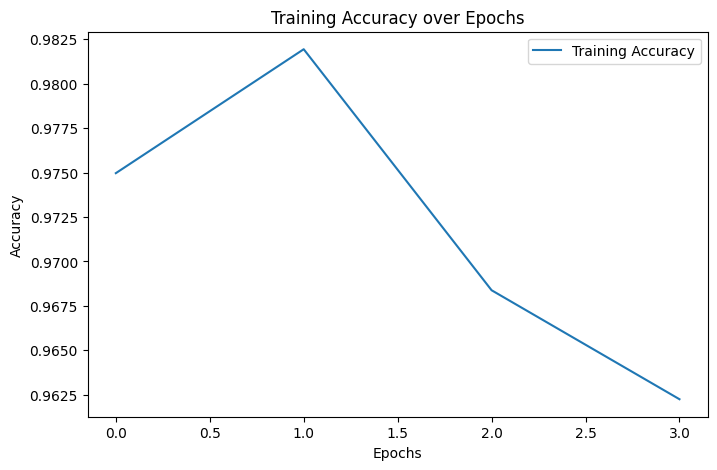

In [20]:
# Plot the training accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(len(eval_logger.train_acc)), eval_logger.train_acc, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

From the graph, we can observe that:

1. Initial Increase in Accuracy: At the beginning, the accuracy increases, which indicates that the model is learning from the training data.

2. Peak at Epoch 1: The accuracy peaks after the first epoch. This suggests that the model has already learned a significant amount from the data and achieved its highest training accuracy at this point.

3. Decline After Epoch 1: There is a decline in accuracy after the first epoch. This decline could be due to several reasons:

- Overfitting: The model might be overfitting to the training data, which means it's learning the noise in the training set rather than generalizable patterns.

- Learning Rate Too High: If the learning rate is too high, the model might be taking steps that are too large in the parameter space and thus 'overshooting' the optimal values it found after the first epoch.

- Inadequate Regularization: If the model is not regularized properly, it might start to fit the training data too closely, reducing its ability to generalize.


4. Continued Decline: The continued decline in accuracy suggests that the model is not stabilizing in its learning and is becoming progressively worse at fitting the training data.

### Compare the performance

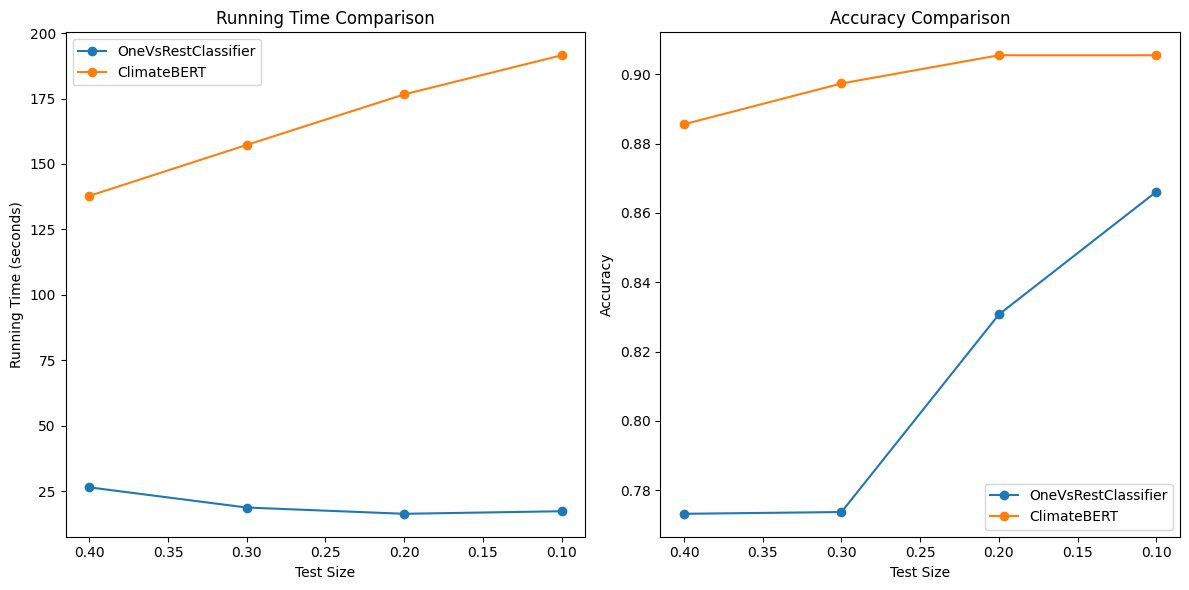

In [22]:
# Plotting Time Comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(test_sizes, times, marker='o', label='OneVsRestClassifier')
plt.plot(test_sizes, climatebert_times, marker='o', label='ClimateBERT')
plt.title('Running Time Comparison')
plt.xlabel('Test Size')
plt.ylabel('Running Time (seconds)')
plt.gca().invert_xaxis()  # To make the test size decrease from left to right
plt.legend()

# Plotting Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(test_sizes, accuracies, marker='o', label='OneVsRestClassifier')
plt.plot(test_sizes, climatebert_accuracies, marker='o', label='ClimateBERT')
plt.title('Accuracy Comparison')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()  # To make the test size decrease from left to right
plt.legend()

plt.tight_layout()
plt.show()

From these two graphs we can observe that the ClimateBERT has much better performance compared with the OneVsRestClassifier, which is not surprising. As the training set increases, the performance of both models rises, but we cannot ignore the potential problem of overfitting, which can be improved in the future.

In general, ClimateBERT is more accurate and reliable than OneVsRestClassifier. In terms of runtime, transfer learning takes more time and the coding can be more complex.

Then we will move to the LLM part - Mistral 7B, to compare their performance.

### Reference

1. Bingler, J. A., Kraus, M., Leippold, M., & Webersinke, N. (2023). How cheap talk in climate disclosures relates to climate initiatives, corporate emissions, and reputation risk. Swiss Finance Institute Research Paper (22-01).
2. Data source: https://huggingface.co/datasets/dspoka/ccai-nlp-tutorial-1
3. https://www.climatechange.ai/tutorials?search=id:nlp-climate-policy-part1